### **Import dependencies**

In [41]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

### **Remove undesired images**

In [2]:
import cv2
import imghdr #To check the file extention

In [3]:
data_dir='D:\mood_classifier_trial\src\data\mood_dataset\data'

### **Remove unwanted file extentions and small sized images**

In [8]:
image_exts=['jpeg','jpg','bmp','png']

In [9]:
from logging import exception
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir,image_class)):
    image_path = os.path.join(data_dir,image_class,image)
    try:
      img=cv2.imread(image_path)
      ext=imghdr.what(image_path)
      size= os.path.getsize(image_path)/1024
      if ext not in image_exts:
        print(f"Image not in ext list {image_path}")
        os.remove(image_path)
      elif size<= 9:
        print(f"Image is too small {image_path}")
        os.remove(image_path)
    except exception as e:
      print(f"Issue with an image {image_path}")


### **Load** **Data**

In [52]:

IMG_SIZE = (224,224)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)


validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 177 files belonging to 2 classes.
Using 124 files for training.
Found 177 files belonging to 2 classes.
Using 53 files for validation.


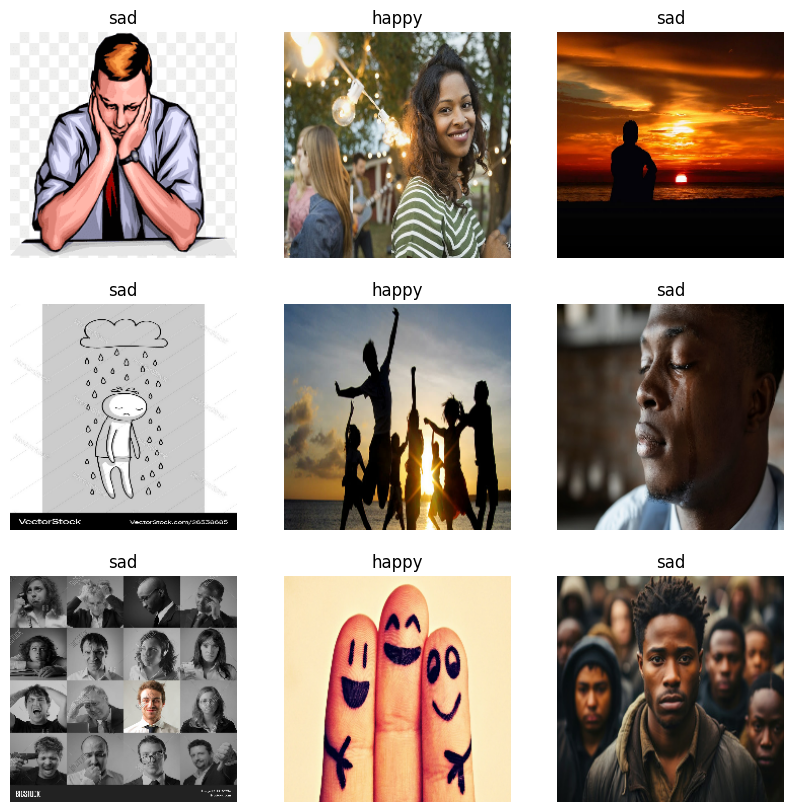

In [45]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [34]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

### **Data Augmentation for the training data**

In [35]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

In [46]:
def data_augmenter():
    """
      creates a sequential model to augment data
    """
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

In [ ]:
data_augmentation=data_augmenter()
for image,_ in train_dataset.take(1):
    plt.figure(figsize=(10,10))
    first_image=image[0]
    

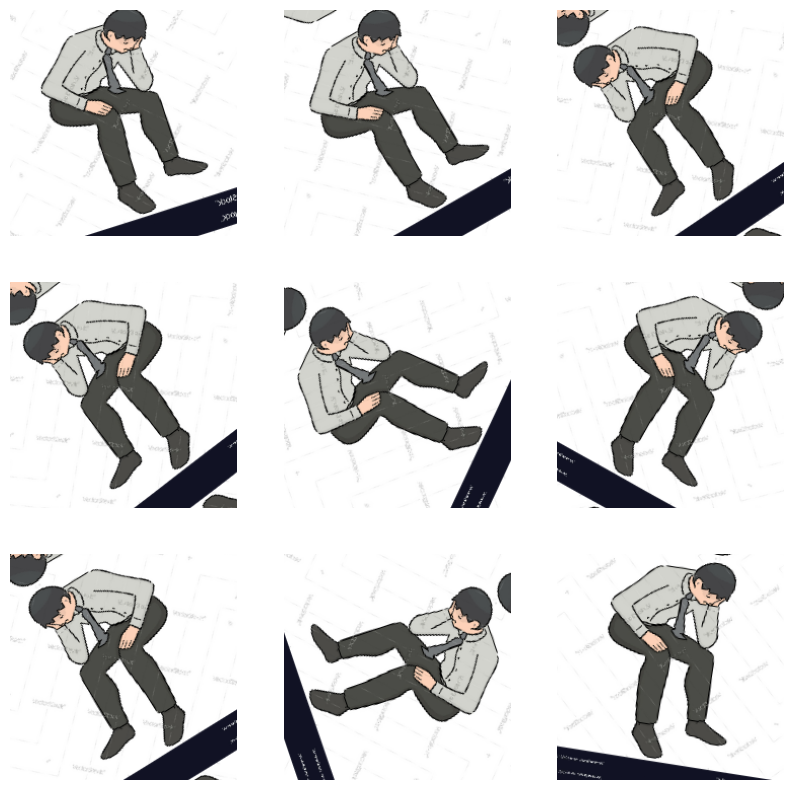

In [47]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0)) ##adds the batch dimension as the keras is expecting a batch
        plt.imshow(augmented_image[0] / 255) #remove the batch dimension and normalize the data between [0,1]
        plt.axis('off')

### **Prepare the dataset for performance**

In [48]:
# Prepare datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [49]:
from tensorflow.keras import layers

# Normalize data
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [50]:
# Build a simple CNN model with data augmentation and normalization
model = tf.keras.Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)


Epoch 1/10


4/4 [==============================] - 20s 3s/step - loss: 2.6783 - accuracy: 0.5242 - val_loss: 1.0221 - val_accuracy: 0.5849
Epoch 2/10
4/4 [==============================] - 11s 3s/step - loss: 0.7300 - accuracy: 0.6371 - val_loss: 0.6230 - val_accuracy: 0.5660
Epoch 3/10
4/4 [==============================] - 11s 3s/step - loss: 0.6454 - accuracy: 0.5968 - val_loss: 0.5818 - val_accuracy: 0.6981
Epoch 4/10
4/4 [==============================] - 11s 3s/step - loss: 0.5602 - accuracy: 0.7500 - val_loss: 0.6276 - val_accuracy: 0.6415
Epoch 5/10
4/4 [==============================] - 10s 3s/step - loss: 0.5949 - accuracy: 0.6774 - val_loss: 0.5290 - val_accuracy: 0.7170
Epoch 6/10
4/4 [==============================] - 11s 3s/step - loss: 0.4815 - accuracy: 0.7661 - val_loss: 0.5021 - val_accuracy: 0.7170
Epoch 7/10
4/4 [==============================] - 10s 3s/step - loss: 0.4354 - accuracy: 0.7903 - val_loss: 0.5385 - val_accuracy: 0.7736
Epoch 8/10
4/4 [=============================

In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

In [66]:
from tensorflow.keras.applications import VGG16
from keras import regularizers
IMG_SIZE=(224,224)
def mood_model(image_shape=IMG_SIZE,data_augmentation=data_augmenter()):
    """
    image_shape -- width and the height of the image
    data_augmentation -- data augmentation function
    """

    input_shape = IMG_SIZE+(3,)
    # Load VGG16 without the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    # Add custom classification layers
    x = data_augmentation(inputs)
    x = base_model(x,training=False)
    # x = tfl.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
   
    x = layers.Dense(512, activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1024, activation='relu',kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='linear')(x)

    # Create the final model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [67]:
#define the model
model2 = mood_model(IMG_SIZE,data_augmentation)

In [68]:
#compile the model
base_learning_rate =0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=['accuracy']
               )


In [69]:
#train the model
initial_epochs = 5
history2 = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5


4/4 [==============================] - 46s 12s/step - loss: 22.6898 - accuracy: 0.5242 - val_loss: 9.6955 - val_accuracy: 0.6415
Epoch 2/5
4/4 [==============================] - 41s 11s/step - loss: 10.6504 - accuracy: 0.6935 - val_loss: 29.5407 - val_accuracy: 0.5283
Epoch 3/5
4/4 [==============================] - 39s 10s/step - loss: 6.0963 - accuracy: 0.7742 - val_loss: 4.9628 - val_accuracy: 0.7547
Epoch 4/5
4/4 [==============================] - 40s 11s/step - loss: 4.7519 - accuracy: 0.8387 - val_loss: 4.5790 - val_accuracy: 0.7547
Epoch 5/5
4/4 [==============================] - 39s 10s/step - loss: 2.9140 - accuracy: 0.9032 - val_loss: 13.3233 - val_accuracy: 0.6604


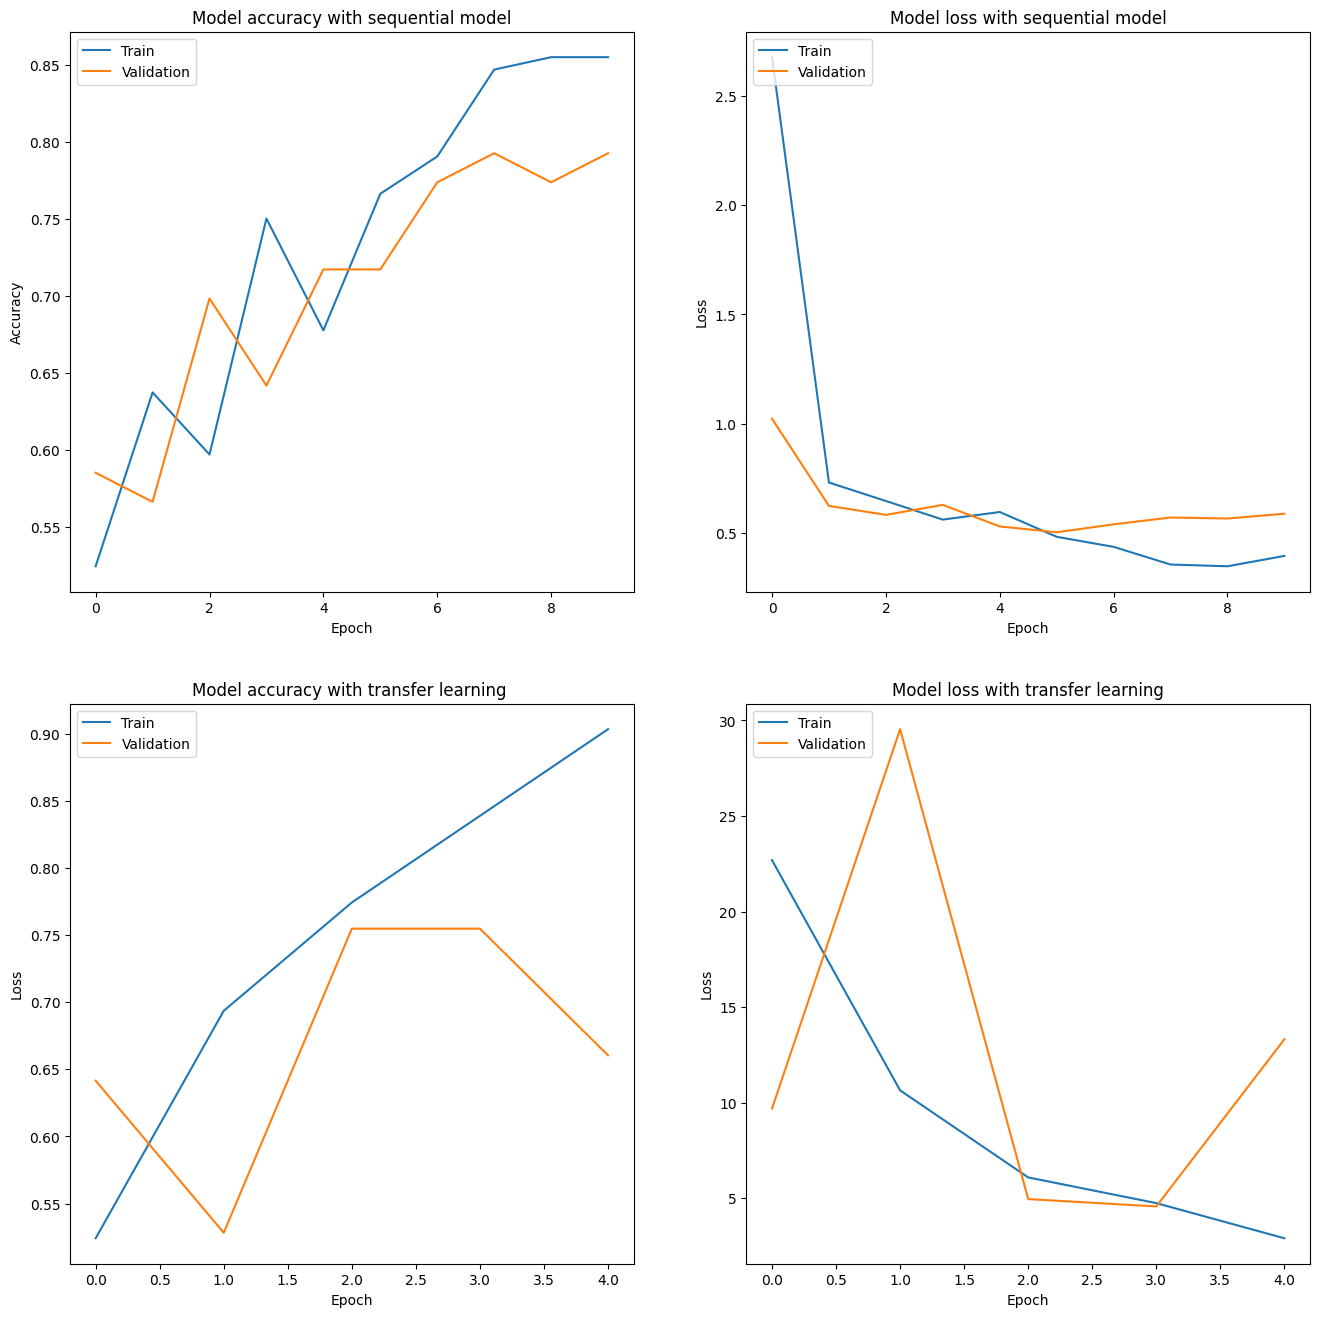

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Plot training & validation accuracy values
plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy with sequential model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss with sequential model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy with transfer learning ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss with transfer learning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



### **Fine Tune**

In [77]:
base_model=model2.layers[2]
len(base_model.layers)
base_model.trainable=True
fine_tune_at = 15
for layer in base_model.layers[:fine_tune_at]:
    layers.trainable=False

loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

In [4]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history2.epoch[-1],
                         validation_data=validation_dataset)

NameError: name 'initial_epochs' is not defined

In [29]:
# Classification report and confusion matrix
y_pred = model.predict(test_dataset)
y_pred = np.round(y_pred).astype(int).reshape(-1)
# print(classification_report(test_labels, y_pred))
# print(confusion_matrix(test_labels, y_pred))

1/1 [==============================] - 1s 741ms/step


In [30]:
y_pred

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0])